# [sklearn](https://scikit-learn.org/stable/modules/classes.html) - песочница для энтузиастов

***Этот семинар:***
- `sklearn.datasets`
- `sklearn.linear_model`
- `sklearn.metrics`

In [1]:
# !pip install --upgrade scikit-learn

In [1]:
import sklearn

sklearn.__version__

'1.3.1'

# Несколько важных слов о линейных моделях

Линейная модель - это:
- `<w, x> + b` / `sign(...)` / `f(...)` - как мы моделируем решение для одного объекта
- `loss` - как мы мыслим понятие ошибки. Влияет на то, как выглядят ***теоретически идеальные*** и ***практически получаемые*** веса
- `solver` - опты или методы аналитического решения задачи ~ как мы добываем ***практически получаемые*** веса

# Линейные модели в sklearn

***План:***
- части тела и интерпретация линейных моделей
- аргументы линейных моделей
- лоссы
- солверы
- `sklearn.linear_model`

## Части тела

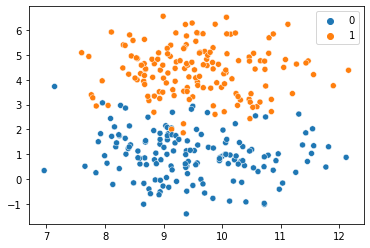

In [1]:
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

X, y = make_blobs(300, centers=2, random_state=4)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()

w: [[0.47741025 2.99442344]] bias: [-12.4915949] <class 'numpy.ndarray'>

y_prob:
 [[2.82837479e-03 9.97171625e-01]
 [5.26288566e-05 9.99947371e-01]
 [1.22999683e-01 8.77000317e-01]]


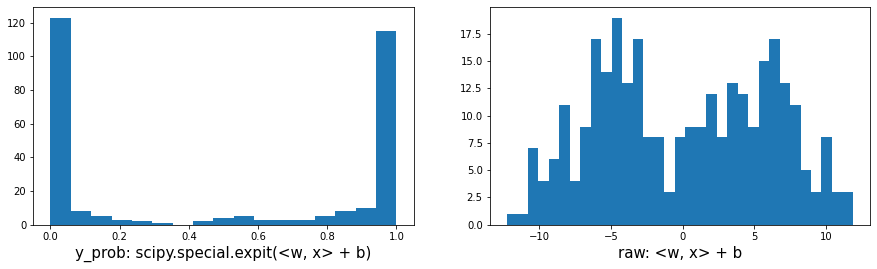

In [2]:
from sklearn.linear_model import LogisticRegression
import numpy as np


model = LogisticRegression()
model.fit(X, y)

print('w:', model.coef_, 'bias:', model.intercept_, type(model.intercept_))

y_prob = model.predict_proba(X)
print('\ny_prob:\n', y_prob[:3])


def anti_expit(expit_x):
    '''1/(1 + e^-x) -> x'''
    return -np.log(1 / expit_x - 1)


mosaic = [['expit', 'raw']]
fig, ax = plt.subplot_mosaic(mosaic, figsize=(15, 4))

ax['expit'].hist(y_prob[:, 1], bins=17)
ax['expit'].set_xlabel('y_prob: scipy.special.expit(<w, x> + b)', fontsize=15)
ax['raw'].hist(anti_expit(y_prob[:, 1]), bins=33)
ax['raw'].set_xlabel('raw: <w, x> + b', fontsize=15)
plt.show()

## Интерпретация

### A - разделяющая прямая с цветами

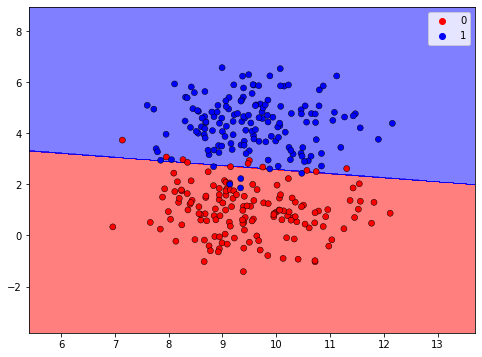

In [3]:
from matplotlib.colors import ListedColormap


def make_meshgrid(x, y, h=.02, odd_range=1):
    '''
    делает координатную сетку по входным точкам
    
    x, y: исходные точки, "вокруг которых" делаем сетку
    h: шаг сетки
    odd_range: величина zoom-out'a от точек х, y
    '''
    x_range = x.max() - x.min()
    y_range = y.max() - y.min()
    x_min, x_max = x.min() - odd_range * x_range, x.max() + odd_range * x_range
    y_min, y_max = y.min() - odd_range * y_range, y.max() + odd_range * y_range
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, model, xx, yy, **params):
    '''
    предсказываем моделью точки сетки и отрисовываем разделяющую прямую и цвета
    
    xx, yy: точки сетки
    '''
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, **params, alpha=0.5)

    
def plot_classification(model, x, y, hue, odd_range=0.3, mesh_h=0.02, figsize=None):
    '''
    рисует разделяющую прямую модели для 2D-задачи классификации
    
    model: что-то, у чего есть метод .predict, который дает ту картину предсказаний, какую вы хотите
    x, y: точки выборки, которые нужно отрисовать вместе с разделяющей прямой
    hue: их классы
    
    odd_range: чем больше, тем больше zoom-out от поданых на вход точек
    mesh_h: шаг сетки
    '''
    # сине-красная палитра
    cmap = ListedColormap(["#FF0000", "#0000FF"])
    palette = sns.color_palette(["#FF0000", "#0000FF"])
        
    fig, ax = plt.subplots(figsize=figsize)
    
    # делаем частую сетку из точек "с центром" в поданных точках x, y
    xx, yy = make_meshgrid(x, y, h=mesh_h, odd_range=odd_range)
    
    # предсказываем моделью все точки сетки, отрисовываем цвета
    plot_contours(ax, model, xx, yy, cmap=cmap)
    
    # отрисовываем туда же поданные на вход точки x, y
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=hue, palette=palette, marker='o', edgecolor='black', ax=ax, legend=True)
    
    
plot_classification(model, X[:, 0], X[:, 1], hue=y, figsize=(8, 6))

### B - интерпретация весов

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,1


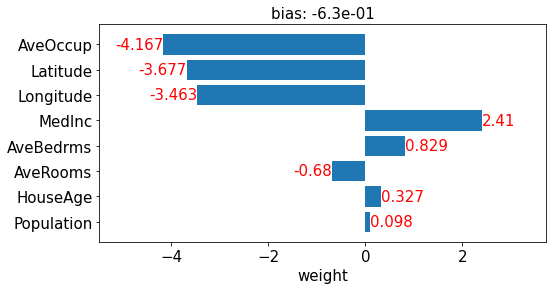

In [4]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
df = data.assign(target=(target > 2).astype(int))
display(df.head(3))

X, y = df.iloc[:, :-1], df.target
features = X.columns

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X.values)


model = LogisticRegression()
model.fit(X, y)

def plot_weights(model, features, top_k=20):
    '''
    рисует значения весов линейной модели при признаках
    
    top_k: рисовать первые top_k весов по модулю
    '''
    # подготовка необходимого
    num_features_to_plot = min(top_k, len(features))
    weights = model.coef_[0]
    sorted_idx = np.argsort(-np.abs(weights))
    bias = model.intercept_[0]
    
    fig, ax = plt.subplots(figsize=(8, num_features_to_plot / 2))
    
    # сами бары
    container = ax.barh(y=features[sorted_idx][:top_k][::-1], width=weights[sorted_idx][:top_k][::-1])
    
    # приписать к ним значения весов
    ax.bar_label(container, weights[sorted_idx][:top_k][::-1].round(3), color='red', fontsize=15)
    
    # настройка ах'a
    ax.margins(0.2, 0.05)
    ax.set_title(f'bias: {bias:.1e}', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('weight', fontsize=15)
    
    plt.show()
    
plot_weights(model, features, top_k=100)

In [5]:
# Забирайте функции себе!

## Аргументы

- `<w, x> + b`
    - fit_intercept
    - positive
    - ...
- `loss`
    - регуляризатор
    - class_weight
    - ...
- `solver`
    - learning_rate
    - max_iter
    - tol
    - early_stopping
    - random_state
    - ...

## [Лоссы](https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation)
- classification
    - `log_loss`
    - `hinge_loss`
    - ...
- regression
    - `squared_error`
    - `huber`
    - `epsilon_insensitive`
    - ...
    
***sklearn не поддерживает кастомные лоссы.*** Исключение - `sklearn.linear_model.RANSACRegressor` 

## [Солверы](https://scikit-learn.org/stable/modules/linear_model.html#solvers)
- прямые методы
    - SVD
    - cholesky
- опты
    - sgd - Stochastic gradient descent
    - sag
    - saga 
    - lbfgs
    - liblinear
    - newton-cg
    - newton-cholesky
    - lsqr
    - sparse cg

## [sklearn.linear_model](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)


- **regression**
    - `sklearn.linear_model.LinearRegression`
        - loss: $||y - a||^2$
        - solver: [scipy.linalg.lstsq, scipy.optimize.nnls]
        
    - `sklearn.linear_model.Ridge`
        - loss: $||y - a||^2 + alpha * ||w||^2_2$
        - solver: ANY
        
    - `sklearn.linear_model.Lasso`
        - loss: $const * ||y - a||^2 + alpha * ||w||_1$
        - solver: coordinate descent
        
    - `sklearn.linear_model.ElasticNet`
        - комбинация Lasso и Ridge
        
    - `sklearn.linear_model.SGDRegressor`
        - loss: ANY
        - solver: SGD
        
    - `sklearn.linear_model.RANSACRegressor`
    - `sklearn.svm.LinearSVC`
    - `sklearn.svm.SVR`
    
    
- **classification**
    - `sklearn.linear_model.LogisticRegression`
        - loss: log_loss
        - solver: ANY
    - `sklearn.linear_model.SGDClassifier`
        - loss: ANY
        - solver: SGD
        
    - `sklearn.svm.LinearSVC`
    - `sklearn.svm.SVC`

# [lightning](https://github.com/scikit-learn-contrib/lightning) - large-scale linear models

In [6]:
# !pip install sklearn-contrib-lightning

In [7]:
import lightning

lightning.__version__

'0.6.2.post0'

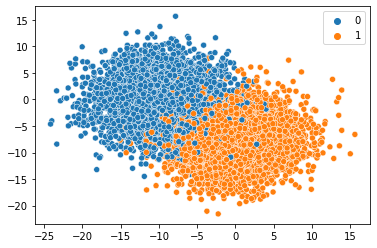

In [8]:
X, y = make_blobs(10_000, centers=2, cluster_std=4, random_state=9)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='saga', C=1, max_iter=100)
model.fit(X, y)
y_prob = model.predict_proba(X)

print('sklearn score:', roc_auc_score(y, y_prob[:, 1]))


from lightning.classification import SAGAClassifier

model = SAGAClassifier(loss='log', alpha=2, max_iter=100)
model.fit(X, y)
y_prob = model.predict_proba(X)

print('lightning score:', roc_auc_score(y, y_prob[:, 1]))

sklearn score: 0.9304678687528889
lightning score: 0.9301376520271111


In [11]:
X, y = make_blobs(3_000_000, centers=2, cluster_std=4)

model = LogisticRegression(solver='saga', C=1, max_iter=100)
%timeit -n1 -r1 -o model.fit(X, y)

model = SAGAClassifier(loss='log', alpha=2, max_iter=100)
%timeit -n1 -r1 -o model.fit(X, y)

_ = '' # чтобы не выводились лишние принты

14.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# *[sklearnex](https://github.com/intel/scikit-learn-intelex) - ускорение sklearn

In [12]:
# !pip install scikit-learn-intelex

In [13]:
X, y = make_blobs(3_000_000, centers=2, cluster_std=4)

model = LogisticRegression(solver='lbfgs', max_iter=100)
%timeit -n1 -r1 -o model.fit(X, y)

_ = ''

2.19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
from sklearnex import patch_sklearn
patch_sklearn()

model = LogisticRegression(solver='lbfgs', max_iter=100)
%timeit -n1 -r1 -o model.fit(X, y)

_ = ''

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


532 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
